# 02806 - Social Data Analysis and Viszalization -  Project Assignment B

# 0. Package and data import

## 0.1 Package import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
import json
import urllib.request
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## 0.2 Data import

### Trip Data

The following data has been retreived from [Citi Bike Trip Histories](https://www.citibikenyc.com/system-data) and
[Citi Bike Stations](https://data.cityofnewyork.us/NYC-BigApps/Citi-Bike-Live-Station-Feed-JSON-/p94q-8hxh). The data consists of features concerning bikeshare traffic in NYC, such as starttime, endtime, duration etc.

In [2]:
def getDataByYear(year):
    '''
    A function to combine the data records of a year to a dataframe.
    Due to different headers in the individual files (spaces, upper and
    lower case letters, etc.), these are normalized.
    Output is a Pandas Dataframe for the requested year.
    '''
    name=""
    df=[]
    
    for k in range(1,13):
        if k<10:
            name = str(year)+"0"+str(k)
        else:
            name = str(year)+""+str(k)
        name +="-citibike-tripdata.csv"
        
        df.append(pd.read_csv('data/'+name))
        #set columns to lower case
        df[k-1].columns = map(str.lower, df[k-1].columns)
        #Filter data 
        df[k-1].columns = [x.replace(" ","") for x in list(df[k-1].columns)]
        df[k-1]["starttime"] = pd.to_datetime(df[k-1]["starttime"], infer_datetime_format=True)
        df[k-1]["stoptime"] = pd.to_datetime(df[k-1]["stoptime"], infer_datetime_format=True)
        
    return pd.concat(df,ignore_index=True)

In [3]:
#Dataset of years 2016-2018
df16=getDataByYear(2016)
df17=getDataByYear(2017)
df18=getDataByYear(2018)

In [4]:
#Merge all trip data
frames = [df16,df17,df18]
df_trips=pd.concat(frames)

### Station data

In [5]:
#Import data from json url. Delete unnecessary columns
with urllib.request.urlopen("https://feeds.citibikenyc.com/stations/stations.json") as url:
    data = json.loads(url.read().decode())
    del data['executionTime']
    data = data['stationBeanList']

#Add data from json objects to list. Only include necessary fields
stations = []
for station in data:
    stations.append([station['id'], station['stationName'], station['latitude'], station['longitude'], station['totalDocks']])

#make dataframe of station info from list derived from json object
df_stations = pd.DataFrame(stations, columns=["id", "stationname", "lat", "long", "capacity"])

# 1. Motivation

For this project we have worked with data concerning Bike Share traffic in New York City. With its many features, this dataset provides a great opportunity to analyze the infrastructure and use, as well as the efficiency, of the bike-share service. Members are often unable to find a bicycle, especially at peak times, and have to rely on other transport routes despite their paid membership. In the long run this could lead to a decrease in the number of members and thus stand in the way of a greener urban life.

Based on recent newspaper articles and criticism from several members, we want to check the following hypothesis: <br> ***The infrastructure of the current bike-sharing solution is not sufficient for the coming growth, that this service is facing.***

We want to check the hypothesis by first identify potential bottlenecks or hotspots based on citibike's trip data and second, analyse and predict the demand of bikes in the given infrastructure.

We therefore hope to be able to contribute to the maintenance of bike-sharing systems by analysing where bottlenecks exist and where there is a need to catch up in the infrastructure. We hope that this will be an analysis model that can also be applied to other cities with bike-sharing systems. 

### 1.1 The Data
In this project two different data sets are used, which are described below.
#### 1.1.1 Trip Data
The trip dataset consists of data for every recorded trip from 2016 to 2018 in NYC. Each trip is described by the features shown in **Table 1.1**.

In [41]:
df_trips.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender
0,923,2016-01-01 00:00:41,2016-01-01 00:16:04,268.0,Howard St & Centre St,40.719105,-73.999733,3002.0,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,2016-01-01 00:00:45,2016-01-01 00:07:04,476.0,E 31 St & 3 Ave,40.743943,-73.979661,498.0,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,2016-01-01 00:00:48,2016-01-01 00:10:37,489.0,10 Ave & W 28 St,40.750664,-74.001768,284.0,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,2016-01-01 00:01:06,2016-01-01 00:15:56,268.0,Howard St & Centre St,40.719105,-73.999733,3002.0,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,2016-01-01 00:01:12,2016-01-01 00:25:52,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


**Table 1.1** Sample of Trip Data

#### 1.1.2 Station Data
The station dataset provides the additional information, *capacity* for every station. Keeping the station name and the coordinates in addition to the ID and the capacity, makes for easy lookup in the Observable notebook.

In [42]:
df_stations.head()

,id,stationname,lat,long,capacity
0,72,W 52 St & 11 Ave,40.767272,-73.993929,55
1,79,Franklin St & W Broadway,40.719116,-74.006667,33
2,82,St James Pl & Pearl St,40.711174,-74.000165,27
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,62
4,119,Park Ave & St Edwards St,40.696089,-73.978034,19


**Table 1.2** Sample of Station Data

# 2. Basic Stats

### 2.1 Data Cleansing and Preprocessing
The preprocessing of the two datasets has been done using *pandas*.
#### 2.1.1 Trip Data
Due to different headers in the individual files (spaces, upper and lower case letters, etc.), the trip data is getting normalized during the import.
Afterwards the data is getting merged in two steps. First all 12 montly files from one year are getting merged. Then the three years getting merged into one dataframe which is shown in **Table 1.1**.
#### 2.1.2 Station Data
The station data is first imported in JSON format, and then converted to a pandas dataframe. Only the necessary features are included, as briefly explained in **1.1.2 - Station Data**. Upon conversion to a dataframe, the features are also renamed.  

### 2.2 Dataset Stats

#### 2.2.1 Trip Data
The trip dataset consists of nearly 48M rows and 15 columns.

In [97]:
print("Lenght of the dataset: "+str(df_trips.shape[0])+"\nAmount of features/columns: "+str(df_trips.shape[1]))

Lenght of the dataset: 47758651
Amount of features/columns: 15


#### 2.2.2 Station Data
The station data consists of 837 rows and 5 columns.

In [98]:
print("Lenght of the dataset: "+str(df_stations.shape[0])+"\nAmount of features/columns: "+str(df_stations.shape[1]))

Lenght of the dataset: 837
Amount of features/columns: 5


### 2.2 Exploratory Analysis

First: Getting a look of which stations are the most popular, and how many trips each station have. As this is only to get an overview, only the from-trips are included. 

In [7]:
startStations=pd.DataFrame({'count' : df_trips.groupby('startstationname').startstationid.count()}).reset_index()
startStations=startStations.sort_values(by=['count'],ascending=False)
startStaTop=startStations[0:50]
startStaBottom=startStations[-50:]

#### 2.2.1 Barchart of Top and Bottom Stations
Plotting the top and bottom 50 stations, based on outgoing trips, provides an overview of the variety in activity of the stations in the data. As one can see in **Figure 2.3** below, the activity variety is quite substantial.

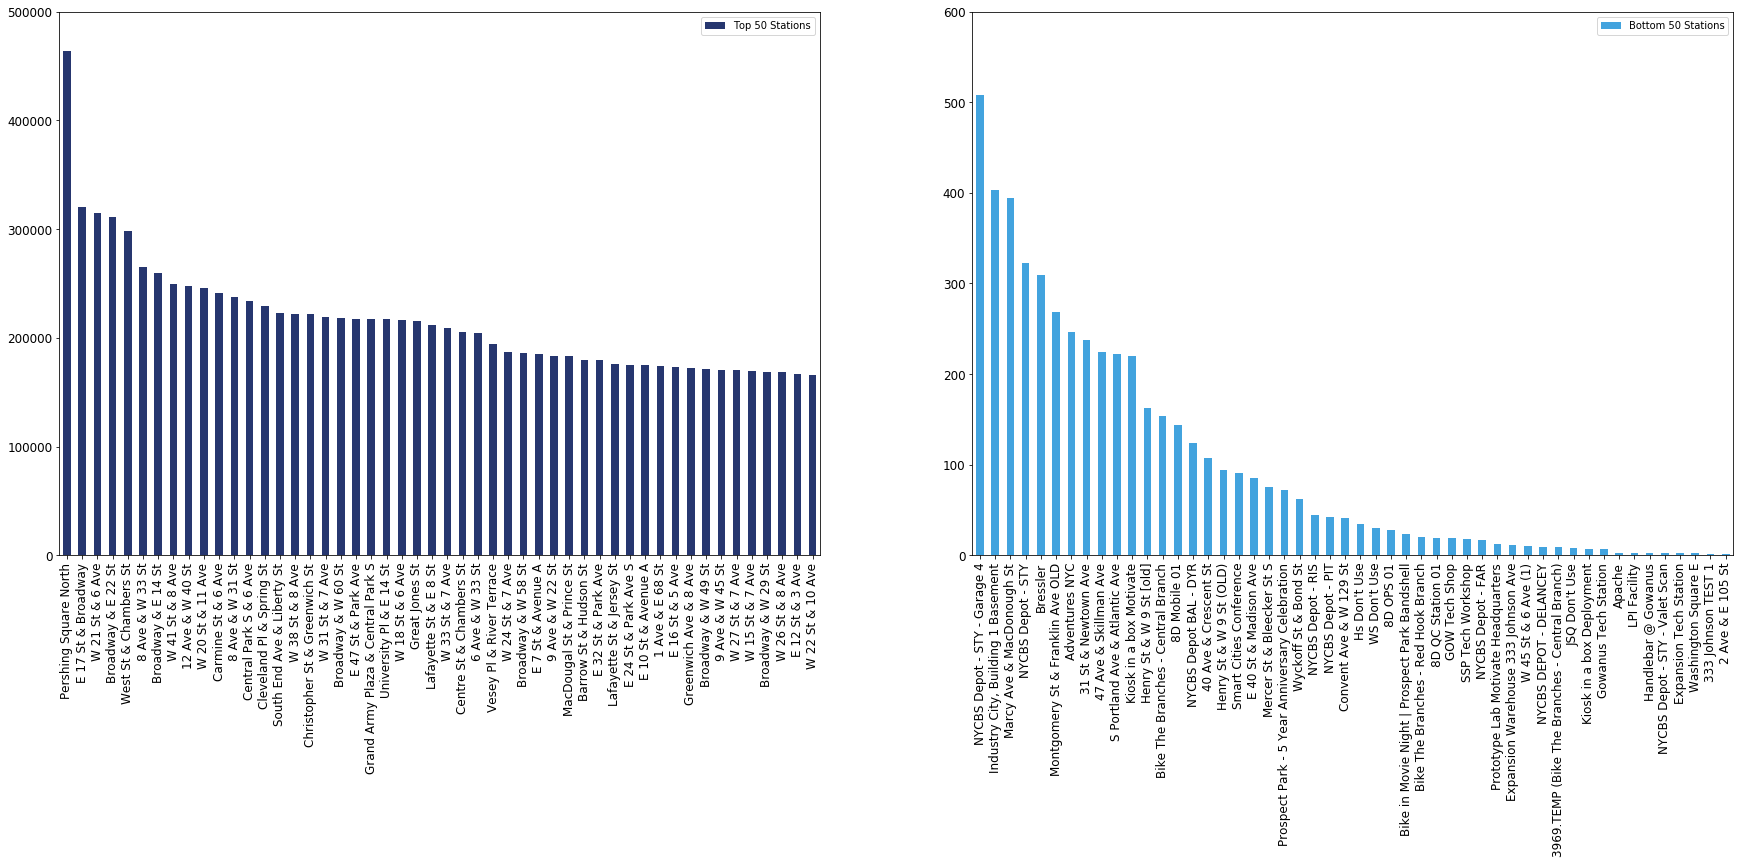

In [39]:
#Plot the histogram with 50 bins
f, ((ax1,ax2)) = plt.subplots(1,2,figsize=(30,10));
my_cmap = ListedColormap(sns.color_palette('husl').as_hex())
startStaTop.plot(kind='bar',xticks=startStaTop.index,rot=90,fontsize=12,ax=ax1,color ='#26366f')
ax1.set_xticklabels(startStaTop.startstationname);
ax1.legend(['Top 50 Stations'])
ax1.set_ylim([0,500000])

startStaBottom.plot(kind='bar',xticks=startStaBottom.index,rot=90,fontsize=12,ax=ax2,color='#42a3de')
ax2.set_xticklabels(startStaBottom.startstationname);
ax2.legend(['Bottom 50 Stations'])
ax2.set_ylim([0,600]);

**Figure 2.1** Barchart of top and bottom 50 stations

#### 2.2.2 Scatter Plots of Stations
As a big part of the analysis is going to deal with geographical analysis. A scatter plot of the stations provides first insights into the geographical distribution over New York City. From the scatter plot in **Figure 2.4**, one can see where the stations are located. The maps are created with Folium, which is based on the Leaflet package.

In [87]:
#Stations in station dataset
m1 = folium.Map([40.730610, -73.935242], zoom_start=11)
# mark each station as a point
scatter_data = df_stations.drop_duplicates()
for index, row in scatter_data.iterrows():
    folium.CircleMarker([row['lat'], row['long']],
                        radius=3,
                        popup=str(row),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m1)
m1

![scatter_stations](https://raw.githubusercontent.com/eikekutz/SocialDataProject/master/img/scatter_station.png)
**Figure 2.4** Scatterplot of Station Data

To see if there are any obvious differences in the station and trip data set, a scatter plot from the trip data is made in **Figure 2.5** below. 

In [46]:
#Prepare data for scatter plot of trip data and a heatmap
start_stat=pd.DataFrame({'count' : df_trips.groupby(['startstationid','startstationlatitude','startstationlongitude']).startstationid.count()}).reset_index()
start_stat = start_stat.rename(columns={'startstationid': 'id', 'startstationlatitude': 'lat','startstationlongitude': 'long'})

end_stat=pd.DataFrame({'count' : df_trips.groupby(['endstationid','endstationlatitude','endstationlongitude']).startstationid.count()}).reset_index()
end_stat = end_stat.rename(columns={'endstationid': 'id', 'endstationlatitude': 'lat','endstationlongitude': 'long'})

start_end = pd.merge(start_stat, end_stat, left_on=['id','lat', 'long'], 
                     right_on=['id','lat', 'long'])
start_end['count'] = start_end['count_x'] + start_end['count_y']
start_end = start_end.drop(['count_x', 'count_y'], axis=1)
start_end.head()

,id,lat,long,count
0,72.0,40.767272,-73.993929,221440
1,79.0,40.719116,-74.006667,161976
2,82.0,40.711174,-74.000165,62769
3,83.0,40.683826,-73.976323,85628
4,116.0,40.741776,-74.001497,186686


In [86]:
#Stations in trip dataset
m2 = folium.Map([40.730610, -73.935242], zoom_start=11)
# mark each station as a point
scatter_data = start_end.drop_duplicates()
for index, row in scatter_data.iterrows():
    folium.CircleMarker([row['lat'], row['long']],
                        radius=3,
                        popup=str(row),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m2)
m2

![trips_stations](https://raw.githubusercontent.com/eikekutz/SocialDataProject/master/img/scatter_trip.png)
**Figure 2.5** Scatter Plot of Trip Data.

By comparing the scatter plots in **Figure 2.4** and **Figure 2.5**, one can see that the station data and the stations from the trip data are not entirely equal. **Figure 2.5** clearly lacks data from Jersey City. This has to be taken into account when doing the main analysis. Stations that are not in both datasets will therefore not be used in the following analyses.

#### 2.2.4 Heatmap of Trip Data

In order to get a better understanding of the data, the heatmap in **Figure 2.6** has been created. The heatmap, that plots the trips of every station, gives a first idea of the most active stations.

In [47]:
k = folium.Map([40.730610, -73.935242], zoom_start=12)

# convert to (n, 2) nd-array format for heatmap
stationArr = start_end[['lat', 'long', 'count']].as_matrix()
max_amount = float(start_end['count'].max())

hm_wide = plugins.HeatMap(stationArr,
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=15, blur=10, 
                   max_zoom=1)

k.add_child(hm_wide)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


![heatmap](https://raw.githubusercontent.com/eikekutz/SocialDataProject/master/img/heatmap.png)
**Figure 2.6** Heatmap of Station Activity

# 3. Data Analysis

The following part of the analysis is designed to answer the individual questions in order to test the main hypothesis. The corresponding visualizations are only displayed in the Observable Notebook.

## 3.1. Station Activity
This part of the analysis describes the procedure of quantifying the use of individual stations.
First the top 200 stations with high interconnectivity are filtered out.
Secondly, a network of all stations and grouped trips between the stations is created.

### 3.1.1. Interconectivity Between Stations - Chord Diagram

Within this project one of the main areas to be investigated is where the main cycling hubs of the bike-sharing system CitiBike are located.<br>
The hotspots then provide information on where the probability of a bottleneck in the availability of bicycles will be higher.<br>
In order to determine the hotspots, the interconnectivity between the individual stations is investigated. 

#### Group trips

In [11]:
chord = df_trips.groupby([df_trips['startstationname'],df_trips['endstationname']])['startstationname'].count().reset_index(name='value')

In [12]:
#Choosing the Top 100 in terms of interconectivity
chord=chord.sort_values('value',ascending=False).head(100)
chord.to_csv('observable_data/chord_data_top100.csv',index=False)

In [13]:
chord.head(5).reset_index(drop=True)

,startstationname,endstationname,value
0,Central Park S & 6 Ave,Central Park S & 6 Ave,25190
1,Central Park S & 6 Ave,5 Ave & E 88 St,16086
2,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,15597
3,W 21 St & 6 Ave,9 Ave & W 22 St,14613
4,12 Ave & W 40 St,West St & Chambers St,14433


**Table 3.1** Sample Table describes the main connections between two stations.

In **Table 3.1** one can see that the main connection starts at Central Park S & 6 Ave and ends there again. The second main connection route also starts from this station.<br>
This data is then transformed into a combination matrix in JavaScript (source code is located in the Observable notebook).
In the corresponding visualization in the Observable Notebook, the viewer can identify which stations and which routes are heavily used. Bike-sharing systems can thus find out in which areas there is a potentially high demand for bicycles.

#### Get corresponding stations available within the dataframe chord
The visualization of the Chord Diagram requires two data sets. One is the already described data set about the main connection routes. The second consists of the corresponding stations (see **Table 3.2**). These could also be generated in Javascript(JS) from one data set, but due to lower computational costs and a better overview these are precomputed in python using pandas.

In [14]:
#Write all start and end stations into a .csv file - workaround for merging them
df_trips.groupby([df_trips['startstationlatitude'],df_trips['startstationlongitude'],df_trips['startstationid'],df_trips['startstationname']])[['endstationid']].count().drop(['endstationid'],axis=1).to_csv('startstations.csv',index=True)
df_trips.groupby([df_trips['endstationlatitude'],df_trips['endstationlongitude'],df_trips['endstationid'],df_trips['endstationname']])[['startstationid']].count().drop(['startstationid'],axis=1).to_csv('endstations.csv',index=True)
#merge both stations
startstations = pd.read_csv('startstations.csv',header=None,names=['latitude','longitude','stationid','stationname'],skiprows=1)
endstations = pd.read_csv('endstations.csv',header=None,names=['latitude','longitude','stationid','stationname'],skiprows=1)
stations =  pd.concat([startstations,endstations]).reset_index(drop=True)
#write combined station file to .csv"
stations.drop_duplicates().reset_index(drop=True)
stations=stations[stations.latitude != 0].reset_index(drop=True)

In [15]:
#Write all start and end stations into a .csv file - workaround for merging them
chord.groupby([chord['startstationname']])[['value']].count().drop(['value'],axis=1).to_csv('chord_startstations.csv',index=True)
chord.groupby([chord['endstationname']])[['value']].count().drop(['value'],axis=1).to_csv('chord_endstations.csv',index=True)
chord_startstations = pd.read_csv('chord_startstations.csv',header=None,names=['stationname'],skiprows=1)
chord_endstations = pd.read_csv('chord_endstations.csv',header=None,names=['stationname'],skiprows=1)
chord_stations =  pd.concat([chord_startstations,chord_endstations])#.drop_duplicates().reset_index(drop=True)
chord_stations.to_csv('observable_data/chord_stations.csv',index=False)


In [16]:
chord_stations.head(5)

,stationname
0,1 Ave & E 62 St
1,11 Ave & W 27 St
2,11 Ave & W 41 St
3,12 Ave & W 40 St
4,46 Ave & 5 St


**Table 3.2** Sample table describing stations you can find in the Chord-diagram

### 3.1.2. Trip-Network - NYC Map of Stations
#### Create nodes for network
The network to be displayed on the map is created in a similar way to the dataframe for chord diagram described above.<br>
Each node represents one station and each edge represents a grouped connection route between stations. The size of the respective node is described by the total number of incoming and outgoing trips (total degree).<br>

In [17]:
#Write all start and end stations into a .csv file - workaround for merging them - this time the column for the count is needed- therefore it is not getting dropped
df_trips.groupby([df_trips['startstationlatitude'],df_trips['startstationlongitude'],df_trips['startstationid'],df_trips['startstationname']])[['endstationid']].count().to_csv('startstations_network.csv',index=True)
df_trips.groupby([df_trips['endstationlatitude'],df_trips['endstationlongitude'],df_trips['endstationid'],df_trips['endstationname']])[['startstationid']].count().to_csv('endstations_network.csv',index=True)

startstations_network = pd.read_csv('startstations_network.csv',header=None,names=['latitude','longitude','stationid','stationname','startcount'],skiprows=1)
endstations_network = pd.read_csv('endstations_network.csv',header=None,names=['latitude','longitude','stationid','stationname','endcount'],skiprows=1)
stations_network=pd.merge(startstations_network, endstations_network,  on=['latitude','longitude','stationid','stationname'])
stations_network.drop_duplicates().reset_index(drop=True)
stations_network=stations_network[stations_network.latitude != 0].reset_index(drop=True)
stations_network.to_csv('observable_data/stations_network.csv',index=False)

In [18]:
stations_network.head(5)

,latitude,longitude,stationid,stationname,startcount,endcount
0,40.445350,-73.978238,160.0,E 37 St & Lexington Ave,8,8
1,40.517975,-74.031372,3036.0,8D OPS 01,3,3
2,40.646538,-74.016588,3239.0,Bressler,309,309
3,40.646678,-74.016303,3245.0,Kiosk in a box Motivate,220,220
4,40.646678,-74.016263,3040.0,SSP Tech Workshop,18,18


**Table 3.3** Sample table describing the data that is needed to create nodes in the network

In **Table 3.3** you can see a sample of nodes that will be shown in the network. The node position ist determined by the its latitude and longitude. The sum of the startcount and the endcount will define the total degree. The summation is done in JS in the observable.<br>
The observer is able to geographically locate the heavily used routes in the Observable Notebook using the this network visualized on a map.

#### Create edges for network

In [19]:
map_network = df_trips.groupby([df_trips['startstationid'],df_trips['startstationname'],df_trips['startstationlatitude'],df_trips['startstationlongitude'],df_trips['endstationid'],df_trips['endstationname'],df_trips['endstationlatitude'],df_trips['endstationlongitude']])['startstationname'].count().reset_index(name='value')

In [32]:
#All grouped trips with the amount of <150 trips within 3 years are getting dropped
mn=map_network.loc[map_network.value>250].reset_index(drop=True)

In [33]:
mn=mn.sort_values(by=['value'],ascending=False).reset_index(drop=True)

In [34]:
mn.to_csv('observable_data/trips_network.csv',index=True)

In [36]:
mn.head(5)

,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,value
0,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,25190
1,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,3282.0,5 Ave & E 88 St,40.783070,-73.959390,16086
2,281.0,Grand Army Plaza & Central Park S,40.764397,-73.973715,281.0,Grand Army Plaza & Central Park S,40.764397,-73.973715,15597
3,435.0,W 21 St & 6 Ave,40.741740,-73.994156,509.0,9 Ave & W 22 St,40.745497,-74.001971,14613
4,514.0,12 Ave & W 40 St,40.760875,-74.002777,426.0,West St & Chambers St,40.717548,-74.013221,14433


**Table 3.4** Sample table describes the individual edges between two stations.

The **Table 3.4** describes the connections between two stations and therefore the edges for the network. The start and end points are defined by their geographical location. The start/end ID is also available. Another feature is the number of trips between the two stations. This serves as a filter for the Observable Notebook. Less important connections are filtered out here to reduce the computational cost when generating SVG on the map.

## 3.2. Demand Analysis and Prediction
This section will first analyse the demand of the different stations and then predict whether the demand is high or low based on a machine learning model. The output will be used to make visualizations in th Observable notebook.

Firstly, the data is sorted on weekdays and hours and then the net count of each station in the given timeframe is calculated. This value will later be used to both predict and calculate the demand.  

#### Delete unnecessary columns and change to datetime objects

In [64]:
df_demand = df_trips.copy()
del_cols = ['tripduration', 'startstationname', 'startstationlatitude', 'startstationlongitude', 'endstationname',
       'endstationlatitude', 'endstationlongitude', 'usertype', 'birthyear', 'gender', 'bikeid']
df_demand = df_demand.drop(del_cols, axis=1)
df_demand['startday'] = df_demand['starttime'].dt.dayofweek
df_demand['stopday'] = df_demand['stoptime'].dt.dayofweek
df_demand['starttime'] = df_demand['starttime'].dt.hour
df_demand['stoptime'] = df_demand['stoptime'].dt.hour

#### Count bikes in and out for weekdays and hours.

In [65]:
df_demand_start = df_demand[['startstationid', 'startday','starttime']]
df_demand_stop = df_demand[['endstationid', 'stopday', 'stoptime']]
df_demand_start= pd.DataFrame({'startcount' : df_demand_start.groupby(['startstationid', 'startday', 'starttime']).size()}).reset_index()
df_demand_stop = pd.DataFrame({'stopcount' : df_demand_stop.groupby(['endstationid', 'stopday', 'stoptime']).size()}).reset_index()

#### Merge in and out data. Add netcount of bikes in each station for every hour and weekday

In [66]:
df_demand_count = pd.merge(df_demand_start, df_demand_stop, left_on=['startstationid', 'startday', 'starttime'], 
                    right_on=['endstationid', 'stopday', 'stoptime'])
df_demand_count = df_demand_count.drop(['endstationid', 'stopday', 'stoptime'], axis=1)
df_demand_count = df_demand_count.rename(columns={'startstationid': 'id', 'startday': 'weekday','starttime': 'hour'})
df_demand_count['id'] = df_demand_count['id'].apply(lambda x : int(x))

#Calculate netcount
df_demand_count['netcount'] = df_demand_count['stopcount'] - df_demand_count['startcount']

In [67]:
df_demand_count.head()

,id,weekday,hour,startcount,stopcount,netcount
0,72,0,0,59,89,30
1,72,0,1,54,46,-8
2,72,0,2,33,23,-10
3,72,0,3,20,12,-8
4,72,0,4,47,18,-29


**Table 3.5** Displays the number of outgoing bikes, incoming bikes, and the 'taken' number of bikes i.e. the netcount. It is grouped by id, weekday, hour.

### 3.2.1 Demand Analysis

#### Find stations that have both incoming and outgoing bikes

In [68]:
df2_demand = df_demand[['startstationid']].drop_duplicates()
df3_demand = df_demand[['endstationid']].drop_duplicates()
df4_demand = pd.merge(df2_demand,df3_demand, how='inner', left_on='startstationid', right_on='endstationid')
df4_demand = df4_demand[['startstationid']].drop_duplicates().dropna()
df4_demand['startstationid'] = df4_demand['startstationid'].apply(lambda x : int(x))
df4_demand.columns = ['id']

#### Find stations that are in both dataset, and merge these. Save data to .csv file.

In [69]:
df_demand_common_stations = pd.merge(df_stations, df4_demand, how='inner', on=['id'])
df_demand_common_stations.to_csv('common_stations.csv', index=False)

#### Calculate demand

In [70]:
df_demand_analysis = pd.merge(df_demand_count,df_demand_common_stations[['id','capacity']],on='id', how='left')

#drop rows with stations that are not in capacity dataset
df_demand_analysis = df_demand_analysis[np.isfinite(df_demand_analysis['capacity'])]

#Demand function. Function is negated to give stations in higher demand a higher value
df_demand_analysis['demand'] = -(df_demand_analysis['netcount'])/df_demand_analysis['capacity']

#Convert id to int
#df_demand_analysis['id'] = df_demand_analysis['id'].apply(lambda x : int(x))

#drop rows with stations that have 0 in capacity
df_demand_analysis = df_demand_analysis[df_demand_analysis.capacity != 0]

#drop duplicates
df_demand_analysis = df_demand_analysis.drop_duplicates()

In [71]:
df_demand_analysis.head()

,id,weekday,hour,startcount,stopcount,netcount,capacity,demand
0,72,0,0,59,89,30,55.0,-0.545455
1,72,0,1,54,46,-8,55.0,0.145455
2,72,0,2,33,23,-10,55.0,0.181818
3,72,0,3,20,12,-8,55.0,0.145455
4,72,0,4,47,18,-29,55.0,0.527273


**Table 3.6** Like *Table 3.5* it displays the number of started trips 'startcount', the 'stopcount' and 'netcount', for each station for each hour and weekday. It also displays the capacity and the calculate demand.

#### Save filtered data to .csv file

In [72]:
df_demand_analysis.to_csv('capacity2.csv', index=False)

### 3.2.2. Demand Prediction
The machine learning model that has been chosen to predict demand, is a decision tree, which is a supervised machine learning method. The machine learning library *scikit.learn* is used to make the model. Therefore the input data X and target values Y must be defined.
The dataframe is therefore grouped by "(station)ID", "weekday", "hour", "startcount" (of bikes) and "stopcount". A final column "netcount" given by "startcount" - "stopcount", is then added to the dataframe.

One observation/example of the input data X to the decision tree is then defined as [ID, "weekday", "hour"]. These input features are chosen, because it seems likely that there should be a correlation between these features and the business of a station. I.e. it seems likely that a station is more busy on a Tuesday at 8am, than on a Saturday at 12pm.

The model is supposed to predict if the netcount is negative ("High Demand") or not ("Low Demand"). The target value y for one observation/example is therefore a one-hot encoded vector indicating "High Demand" or "Low Demand".
The data is furthermore shuffled, before divided into training and test sets. The data is then fit (trained) on the decision tree, and tested on the test set. The accuracy is about 78.5% on the test set. Finally, the decision tree is exported as a JSON file for visualization.

#### Define input features and target values. Shuffle the data.

In [73]:
# Defines input features and target values
X = df_demand_count[['id','weekday','hour']].values
y1 = df_demand_count[['netcount']].values

# Data Prep
y = np.array(["high demand" if n<0 else "low demand" for n in y1])
class_idx = {'high demand':1, 'low demand':0}

y = np.array([class_idx[v] for v in y])
y = np.eye(2)[y]


# Shuffles the data
random_idx = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(random_idx)

X = X[random_idx]
y = y[random_idx]

#### Split the data into training and test

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train data
The decision tree needs to be prepared twice. Once for the actual prediction which is done in the jupyter notebook and a second one for displaying purposes in the observable notebook. The latter one has a smaller depth, but therefore also a lower accuracy.

*For Jupyter Notebook*

In [75]:
DT = DecisionTreeClassifier(min_samples_split=13, criterion = "entropy")
DT.fit(X_train, y_train)
predictions = DT.predict(X_test)

*For Observable Notebook* <br>
max_depth = 5 for the desicion tree to fit into the observable notebook

In [77]:
DT_obs = DecisionTreeClassifier(min_samples_split=13, max_depth = 5, criterion = "entropy")
DT_obs.fit(X_train, y_train)
predictions_obs = DT_obs.predict(X_test)

#### Accuracy 

*For Jypyter Notebook*

In [78]:
true = y_test.argmax(axis=1)
correct_preds = np.equal(true, predictions.argmax(axis=1))
print("Accuracy:", sum(correct_preds) / len(true))

Accuracy: 0.7847902783222266


*For Observable Notebook*

In [79]:
true = y_test.argmax(axis=1)
correct_preds = np.equal(true, predictions_obs.argmax(axis=1))
print("Accuracy:", sum(correct_preds) / len(true))

Accuracy: 0.6179038523217276


#### Calculate the Mean Squared Error (MSE)

In [80]:
def MSE(X, y, DT):
        
        # Predict
        yhat = DT.predict(X)
    
        # Calculate MSE
        return np.mean((y-yhat)**2)

*For Jupyter Notebook*

In [104]:
print("Generalization Error: ", MSE(X_test, y_test, DT))

Generalization Error:  0.21483553686611312


*For Observable Notebook*

In [106]:
print("Generalization Error: ", MSE(X_test, y_test, DT_obs))

Generalization Error:  0.38222087594882576


#### Create desicion tree

In [83]:
def rules(clf, features, labels, node_index=0):
    """Structure of rules in a fit decision tree classifier

    Parameters
    ----------
    clf : DecisionTreeClassifier
        A tree that has already been fit.

    features, labels : lists of str
        The names of the features and labels, respectively.

    """
    node = {}
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        count_labels = zip(clf.tree_.value[node_index, 0], labels)
        node['name'] = ', '.join(('{} of {}'.format(int(count), label)
                                  for count, label in count_labels))
    else:
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        node['name'] = '{} > {}'.format(feature, threshold)
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        node['children'] = [rules(clf, features, labels, right_index),
                            rules(clf, features, labels, left_index)]
    return node

#### Create JSON file with decision tree

In [84]:
feature_names = ['StationID', 'Weekday', 'Hour']
target_names = ["LD", "HD"]

r = rules(DT_obs, feature_names, target_names)

with open('desicion_tree.json', 'w') as f:
    f.write(json.dumps(r))

# 4. Genre

The genre of visualization in this project is exclusively the annotated chart to tell the narrative story. This was chosen because of its simplistic style, and it provides a great opportunity for user interactivity, as well as user exploration. Due to the nature of the main dataset mostly consisting of geographic data, we deemed this the most suitable genre of visualizing for the chosen dataset.

To aid the visual narrative, *timebars* were used for visual structuring (this is for example seen with the sliders for the heatmaps), zooming was used for highlighting, and animated transitions were used for user guidance.

For structuring the narrative, we have used the following tools: Hover highlighting in visualizations such as in the Chord Diagram, as well as a few buttons and sliders for navigation through the visualizations. Every visualization has a default view. The ordering of the structure is user directed, as there is no one single way to go through the narrative. However, due to the limitations of the chosen single page Observable notebook, the ordering naturally follows the scrolling of the notebook.

# 5. Visualizations
The narrative story in the observable notebook contains 5 visualizations, which are described further below.
## 5.1 Hotspots
The visualization that represents the hotspots of traffic consists of two parts that interact unidirectionally with each other. It consists of a chord diagram and a geographical network. This combination can then be used to quickly and easily determine which of the most visited stations are what they are called and where they can be found geographically.
### 5.1.1 Chord diagramm
A chord diagram is particularly suitable to illustrate the relationships between different elements and demonstrate what they have in common. It can therefore be used to display the similarities within features from a dataset ([The Data Visualisation Catalogue](https://datavizcatalogue.com/methods/chord_diagram.html)).<br>
Within this project the chord diagram is used to represent the interconnectivity between stations.  It visualizes how many trips share the same start and end stations.<br>
The chord diagram was the easiest to understand visualization next to the network representation and is therefore used in this project. Alternatively, a Sankey diagram could be used. However, this was not suitable due to the high number of stations and the resulting size. 

### 5.1.2 Geographical network
Another possibility to identify the hotspots from a data set that contains a high interconectivity is a network representation. The nodes represent the elements that consist of the data points  and the edges represent the corresponding connection between the elements.Within this project the nodes represent the station and the edges the grouped connection.<br>
The network representation was chosen because it is an easy way to display many data at once without losing much clarity. In connection with the choir diagram, a selected station is then also geographically assigned.

## 5.2 Demand Analysis
For the demand analysis, a heatmap and barcharts are chosen. Together with two sliders that decides timeframe, they provide a representation of the demand of the bike stations in NYC.

### 5.2.1 Heatmap 
A heatmap provides for an easy and clear overview of the distribution of data. As the goal of the analysis is to look at the distribution of demand of the different stations, the heatmap is very useful. In addition, the user can zoom and click on each station for more information of that particular station. This self exploratory functionality enchances the user experience. 

### 5.2.2 Barchart
Whereas the heatmap gives a good overview of the demand, the barchart gives detailed information about the most and least in demand stations, complimenting the heatmap. Each bar represents the netcount, i.e. the difference of trips going in and trips going out of that station. The barcharts are complimented by a scatterplot that represents the station capacity, which is supposed to act as an integral part of the barchart. This way, all the information used to calculate the demand is also found in the barcharts.

## 5.3 Demand Prediction

### 5.3.3 Desicion Tree
The visualization of the decision tree directly shows the decision making progress the computer makes when predicting the demand of a station. We would therefore argue that it is an important visualization to make for the users, who arguably wouldn't know anything about machine learning. The user is able to follow the tree from the root, to any leaf, following the decision making progress - in essence "predicting" the demand of a station.

# 6. Discussion


The aim of this project was to find out where weaknesses can be found in the infrastructure which can be attributed to a too small number of bicycles at different stations.<br>

With our analysis and the visualization based on it, the main nodes within the bike-sharing system can be filtered out relatively simply and assigned geographically. Furthermore, with the help of the analysis of the time and weekday-related demand for bikes at certain stations, it is possible to find out which stations are sufficiently equipped with bikes measured against their target capacity.It is also possible to make a simple prediction using a decission tree about whether a station has a high or low demand.<br>
It is thus possible to find out where the focus of use is and at which stations the use exceeds the number of bicycles available.<br>
Also, various visualizations are provided that allow the viewer to interactively find out where stations and routes are heavily used and where there is a high demand for bicycles (see [Observable Notebook](https://observablehq.com/d/c1fce6d5874eb0a3))

For a better analysis in terms of sufficient infrastructure, information on an exact number of bicycles available per station is missing. At the moment this value is approximated based on the trip data. However, this value does not have to correspond to reality, as bicycles can also be transported by the company between stations or collected for overhaul.

Furthermore, the prediction of demand is currently only possible in binary form. Choosing another model that is more suitable for mutivariate data sets will probably achieve a higher accuracy at this point than a decison tree. 
Currently the observable notebook provides the user only with a visualization of the decison tree. To improve this, a part for the usage of the prediction for the user could be included.

Moreover, our analysis does not take into account the evolution of demand over the years. This could be realized by further visualizations.

# 7. Contributions

The areas of responsibility listed below are valid for both the Jupyter notebook and the Observable notebook.

* **Station Activity / Hotspots:**  Eike
* **Demand Analysis:** Lars
* **Demand Prediction:** Holger
* **Writing, merging and formatting:** Everybody

# 8. Sources:

- Scikit.learn visualization using d3: https://planspace.org/20151129-see_sklearn_trees_with_d3/  
- Trip Data: https://www.citibikenyc.com/system-data  
- Station Data: https://feeds.citibikenyc.com/stations/stations.json
- The Data Visualisation Catalogue: https://datavizcatalogue.com/methods/chord_diagram.html